In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [3]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(True),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.ReLU(True),
            nn.Linear(hidden_dim * 4, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)


class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(mnist, batch_size=128, shuffle=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [01:07<00:00, 145825.69it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 101081.27it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:03<00:00, 433653.48it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4543412.54it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
input_dim = 100
output_dim = 28 * 28
hidden_dim = 256
lr = 0.0002

generator = Generator(input_dim, output_dim, hidden_dim).to(device)
discriminator = Discriminator(output_dim, hidden_dim).to(device)

optimizer_g = optim.Adam(generator.parameters(), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

criterion = nn.BCELoss()


In [6]:
def train_gan(dataloader, generator, discriminator, optimizer_g, optimizer_d, criterion, num_epochs=50):
    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.view(batch_size, -1).to(device)
            
            # Labels
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # Train Discriminator
            outputs = discriminator(real_images)
            d_loss_real = criterion(outputs, real_labels)
            real_score = outputs

            z = torch.randn(batch_size, input_dim).to(device)
            fake_images = generator(z)
            outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion(outputs, fake_labels)
            fake_score = outputs

            d_loss = d_loss_real + d_loss_fake
            optimizer_d.zero_grad()
            d_loss.backward()
            optimizer_d.step()

            # Train Generator
            z = torch.randn(batch_size, input_dim).to(device)
            fake_images = generator(z)
            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels)

            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()

            if (i+1) % 200 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], '
                      f'D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}, '
                      f'D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')
                
        save_fake_images(epoch, generator)

def save_fake_images(epoch, generator, result_dir='./results'):
    z = torch.randn(64, input_dim).to(device)
    fake_images = generator(z)
    fake_images = fake_images.view(fake_images.size(0), 1, 28, 28)
    fake_images = (fake_images + 1) / 2.0

    fig, ax = plt.subplots(8, 8, figsize=(8, 8))
    for i in range(8):
        for j in range(8):
            ax[i, j].imshow(fake_images[i*8 + j][0].cpu().detach().numpy(), cmap='gray')
            ax[i, j].axis('off')
    plt.savefig(f'{result_dir}/fake_images_epoch_{epoch+1}.png')
    plt.close()


Epoch [1/50], Step [200/469], D Loss: 0.2986, G Loss: 3.9789, D(x): 0.95, D(G(z)): 0.06
Epoch [1/50], Step [400/469], D Loss: 0.1696, G Loss: 9.3901, D(x): 0.98, D(G(z)): 0.08


FileNotFoundError: [Errno 2] No such file or directory: './results/fake_images_epoch_1.png'

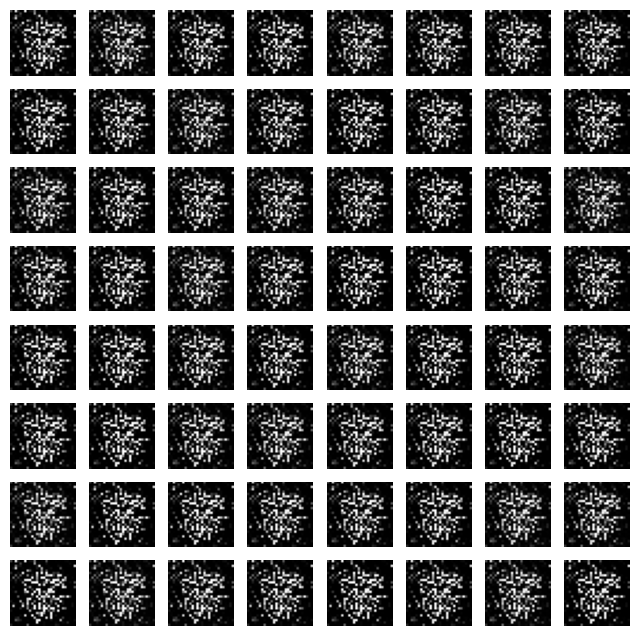

In [7]:
num_epochs = 50
train_gan(dataloader, generator, discriminator, optimizer_g, optimizer_d, criterion, num_epochs)


In [8]:
import os


In [9]:
def save_fake_images(epoch, generator, result_dir='./results'):
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    
    z = torch.randn(64, input_dim).to(device)
    fake_images = generator(z)
    fake_images = fake_images.view(fake_images.size(0), 1, 28, 28)
    fake_images = (fake_images + 1) / 2.0

    fig, ax = plt.subplots(8, 8, figsize=(8, 8))
    for i in range(8):
        for j in range(8):
            ax[i, j].imshow(fake_images[i*8 + j][0].cpu().detach().numpy(), cmap='gray')
            ax[i, j].axis('off')
    plt.savefig(f'{result_dir}/fake_images_epoch_{epoch+1}.png')
    plt.close()


In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(True),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.ReLU(True),
            nn.Linear(hidden_dim * 4, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)


class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(mnist, batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
input_dim = 100
output_dim = 28 * 28
hidden_dim = 256
lr = 0.0002

generator = Generator(input_dim, output_dim, hidden_dim).to(device)
discriminator = Discriminator(output_dim, hidden_dim).to(device)

optimizer_g = optim.Adam(generator.parameters(), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

criterion = nn.BCELoss()

def train_gan(dataloader, generator, discriminator, optimizer_g, optimizer_d, criterion, num_epochs=50):
    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.view(batch_size, -1).to(device)
            
            # Labels
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # Train Discriminator
            outputs = discriminator(real_images)
            d_loss_real = criterion(outputs, real_labels)
            real_score = outputs

            z = torch.randn(batch_size, input_dim).to(device)
            fake_images = generator(z)
            outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion(outputs, fake_labels)
            fake_score = outputs

            d_loss = d_loss_real + d_loss_fake
            optimizer_d.zero_grad()
            d_loss.backward()
            optimizer_d.step()

            # Train Generator
            z = torch.randn(batch_size, input_dim).to(device)
            fake_images = generator(z)
            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels)

            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()

            if (i+1) % 200 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], '
                      f'D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}, '
                      f'D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')
                
        save_fake_images(epoch, generator)

def save_fake_images(epoch, generator, result_dir='./results'):
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    
    z = torch.randn(64, input_dim).to(device)
    fake_images = generator(z)
    fake_images = fake_images.view(fake_images.size(0), 1, 28, 28)
    fake_images = (fake_images + 1) / 2.0

    fig, ax = plt.subplots(8, 8, figsize=(8, 8))
    for i in range(8):
        for j in range(8):
            ax[i, j].imshow(fake_images[i*8 + j][0].cpu().detach().numpy(), cmap='gray')
            ax[i, j].axis('off')
    plt.savefig(f'{result_dir}/fake_images_epoch_{epoch+1}.png')
    plt.close()

num_epochs = 50
train_gan(dataloader, generator, discriminator, optimizer_g, optimizer_d, criterion, num_epochs)


Epoch [1/50], Step [200/469], D Loss: 0.0567, G Loss: 4.6998, D(x): 0.97, D(G(z)): 0.01
Epoch [1/50], Step [400/469], D Loss: 0.0924, G Loss: 7.5493, D(x): 0.97, D(G(z)): 0.02
Epoch [2/50], Step [200/469], D Loss: 0.0209, G Loss: 9.0474, D(x): 1.00, D(G(z)): 0.02
Epoch [2/50], Step [400/469], D Loss: 0.0240, G Loss: 7.8686, D(x): 0.99, D(G(z)): 0.01
Epoch [3/50], Step [200/469], D Loss: 0.0162, G Loss: 12.6604, D(x): 1.00, D(G(z)): 0.01
Epoch [3/50], Step [400/469], D Loss: 0.1968, G Loss: 7.0501, D(x): 0.92, D(G(z)): 0.04
Epoch [4/50], Step [200/469], D Loss: 0.3372, G Loss: 4.2551, D(x): 0.86, D(G(z)): 0.14
Epoch [4/50], Step [400/469], D Loss: 0.0897, G Loss: 10.3450, D(x): 0.98, D(G(z)): 0.05
Epoch [5/50], Step [200/469], D Loss: 0.8761, G Loss: 2.4496, D(x): 0.82, D(G(z)): 0.35
Epoch [5/50], Step [400/469], D Loss: 0.3111, G Loss: 2.0432, D(x): 0.90, D(G(z)): 0.16
Epoch [6/50], Step [200/469], D Loss: 0.7883, G Loss: 2.1144, D(x): 0.75, D(G(z)): 0.13
Epoch [6/50], Step [400/469], 